# Un projet test sur pytorch
    Pour ceci c'est le dataset sur le digits de sklearn qui sera utiliser 
    

In [86]:
from sklearn.datasets import load_digits
from torch import nn
import torch
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

### Charge les donnees

In [87]:
dataset= load_digits()
features= dataset['images']
targets= dataset['target']
print(features.shape)
print(targets.shape)

(1797, 8, 8)
(1797,)


### Affichage d'une image pixeliser d'un nombre

<Figure size 432x288 with 0 Axes>

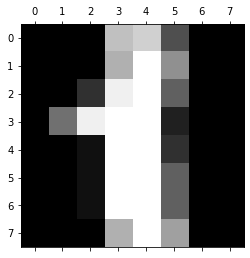

In [88]:
import matplotlib.pyplot as plt
plt.gray()
plt.matshow(features[1])
plt.show()

### Standarisation des donnees

In [89]:
features=features.reshape(-1, 64)
print(features.shape)
standard=StandardScaler()
features=standard.fit_transform(features)

(1797, 64)


In [90]:
#transformer les donnees en tensor
features= torch.tensor(features).type(torch.cuda.FloatTensor)
targets= torch.tensor(targets).type(torch.cuda.FloatTensor)
print(features.shape)
print(targets.shape)

torch.Size([1797, 64])
torch.Size([1797])


### Division des donnees en train et test set

In [91]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(features, targets, test_size=.3)
print("X_train: ", X_train.shape, " X_test: ", X_test.shape)
print("y_train: ", y_train.shape, " y_test: ", y_test.shape)

X_train:  torch.Size([1257, 64])  X_test:  torch.Size([540, 64])
y_train:  torch.Size([1257])  y_test:  torch.Size([540])


In [92]:
from torch.utils.data import TensorDataset

trainData= TensorDataset(X_train, y_train)
testData= TensorDataset(X_test, y_test)

### charge les donnees avec les DataLoader avec un batch precis

In [93]:
batch=70
dataTrain=DataLoader(trainData, batch_size=batch, shuffle=True)
dataTest=DataLoader(testData, batch_size=batch, shuffle=True)

for x, y in dataTrain:
    print(x.shape, " | ", y.shape)
    print(x.dtype, " | ", y.dtype)
    break
    
for x, y in dataTest:
    print(x.shape, " | ", y.shape)
    print(x.dtype, " | ", y.dtype)
    break

torch.Size([70, 64])  |  torch.Size([70])
torch.float32  |  torch.float32
torch.Size([70, 64])  |  torch.Size([70])
torch.float32  |  torch.float32


### creation de RNN avec torch.nn

In [94]:
device= "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(device)

cuda


In [95]:
class reseauNeuronal(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten=nn.Flatten()
        self.linear_relu=nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu(x)
        return logits

model=reseauNeuronal().to(device)
print(model)

reseauNeuronal(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


### Train et test le modele

In [96]:
optimizer= torch.optim.SGD(model.parameters(), lr=1e-3)
loss= nn.CrossEntropyLoss()

def train(datatrain, model, loss, optimizer):
    size=len(datatrain.dataset)
    model.train()
    for batch, (x, y) in enumerate(datatrain):
        y = y.type(torch.LongTensor) 
        x, y = x.to(device), y.to(device)
        pred= model(x)
        lossTrain= loss(pred, y)

        optimizer.zero_grad()
        lossTrain.backward()
        optimizer.step()
        if batch%100 == 0:
            loss_train, current = lossTrain.item(), batch*len(x)
            print(f"loss: {loss_train:>7f} [{current:>5d}/{size:>5d}]")
            
            
def test(dataTest, model, loss):
    lossTest, correct= 0, 0
    size=len(dataTest.dataset)
    numBatch=len(dataset)
    model.eval()
    
    with torch.no_grad():
        for x, y in dataTest:
            y= y.type(torch.LongTensor)
            x, y = x.to(device), y.to(device)
            pred = model(x)
            lossTest += loss(pred, y).item()
            correct += (pred.argmax(1)==y).type(torch.float).sum().item()
    lossTest /= numBatch
    correct /= size
    print("loss: ", lossTest, "Accuracy: ", correct)

In [97]:
for i in range(0,10):
    print("Epoch ", i, " -----------------------------------------------")
    train(dataTrain, model, loss, optimizer)
    test(dataTest, model, loss)
    print("! DONE \n")

Epoch  0  -----------------------------------------------
loss: 2.309944 [    0/ 1257]
loss:  2.6469126428876604 Accuracy:  0.06481481481481481
! DONE 

Epoch  1  -----------------------------------------------
loss: 2.329922 [    0/ 1257]
loss:  2.6435584340776717 Accuracy:  0.07407407407407407
! DONE 

Epoch  2  -----------------------------------------------
loss: 2.310133 [    0/ 1257]
loss:  2.64021829196385 Accuracy:  0.08333333333333333
! DONE 

Epoch  3  -----------------------------------------------
loss: 2.326340 [    0/ 1257]
loss:  2.6360715116773332 Accuracy:  0.08703703703703704
! DONE 

Epoch  4  -----------------------------------------------
loss: 2.313391 [    0/ 1257]
loss:  2.6325701645442416 Accuracy:  0.0962962962962963
! DONE 

Epoch  5  -----------------------------------------------
loss: 2.303829 [    0/ 1257]
loss:  2.6288363933563232 Accuracy:  0.1
! DONE 

Epoch  6  -----------------------------------------------
loss: 2.298576 [    0/ 1257]
loss:  2.62547